In [1]:
import sys
print(sys.executable)

/home/rs/PycharmProjects/snake-multi/.venv/bin/python3.10


In [2]:
import os
os.chdir("../..")
os.getcwd()

'/home/rs/PycharmProjects/snake-multi'

In [3]:
import random
import logging
import sys
from collections import deque
from functools import partial
from math import floor, ceil

import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.simulation.simulation import Simulation, Vector2
from src.simulation.board_generator import make_simple_board

from src.model.model_utils import get_model_moves, get_model_scores, get_rotated_state

tf.config.experimental.set_memory_growth(tf.config.list_physical_devices("GPU")[0], True)

2025-09-03 20:51:26.755050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756925486.766670  124972 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756925486.770252  124972 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756925486.780130  124972 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756925486.780143  124972 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756925486.780144  124972 computation_placer.cc:177] computation placer alr

In [4]:
view_range = 7
replay_buffer_size = 10_000

In [5]:
def calculate_score(ate_food: bool, died: bool):
    if died:
        return -10

    if ate_food:
        return 10

    return 0

In [6]:
cat_encoding = tf.keras.layers.CategoryEncoding(num_tokens=6, output_mode="one_hot")

cat_encoding([[3, 2, 1, 5], [5, 3, 1, 3]])

I0000 00:00:1756925488.507285  124972 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1700 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1


<tf.Tensor: shape=(2, 4, 6), dtype=float32, numpy=
array([[[0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.]]], dtype=float32)>

In [7]:
#online_model = tf.keras.Sequential([
#    tf.keras.layers.Input((view_range * 2 + 1, view_range * 2 + 1)),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.CategoryEncoding(num_tokens=6, output_mode="one_hot"),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(42, activation="relu", kernel_initializer="he_normal"),
#    tf.keras.layers.Dense(42, activation="relu", kernel_initializer="he_normal"),
#    tf.keras.layers.Dense(1)
#])

Dense = partial(tf.keras.layers.Dense, activation="relu", kernel_initializer="he_normal")

online_model = tf.keras.Sequential([
    tf.keras.layers.Input((5 * 4,)),
    Dense(64),
    Dense(64),
    tf.keras.layers.Dense(1)
])

target_model = tf.keras.models.clone_model(online_model)
target_model.set_weights(online_model.get_weights())

view_type = "simple"

In [8]:
model_name = "r7_simple_rb_1_3_e_1000_lr_001"

In [9]:
logging.basicConfig(level=logging.DEBUG)

log_formatter = logging.Formatter("%(message)s")

std_handler = logging.StreamHandler(sys.stdout)
std_handler.setLevel(logging.INFO)
std_handler.setFormatter(log_formatter)

file_handler = logging.FileHandler(f"logs_{model_name}.log")
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(log_formatter)

logger = logging.getLogger()
logger.handlers.clear()
logger.addHandler(std_handler)
logger.addHandler(file_handler)

In [10]:
online_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,569 (21.75 KB)

 Trainable params: 5,569 (21.75 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
simulation = Simulation(calculate_score)
simulation.reset(make_simple_board(np.array([view_range * 2 + 1, view_range * 2 + 1])), 2, 1)

online_model.predict(np.array([simulation.get_snake_view(0, view_type, view_range)]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


I0000 00:00:1756925489.042377  125036 service.cc:152] XLA service 0x7fe21c004ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756925489.042403  125036 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 3GB, Compute Capability 6.1
2025-09-03 20:51:29.046862: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1756925489.057489  125036 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756925489.134178  125036 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


array([[12.295884]], dtype=float32)

In [12]:
def epsilon_greedy(snakes_states: list[np.ndarray], snakes_possible_moves: list[list[Vector2]], snakes_alive: list[bool], epsilon: float=0.):
    n_snakes = len(snakes_states)

    process_mask = [True for _ in range(n_snakes)]
    
    for i, alive in enumerate(snakes_alive):
        if not alive or np.random.rand() < epsilon:
            process_mask[i] = False

    moves = get_model_moves(online_model, snakes_states, snakes_possible_moves, process_mask, softmax=True)

    for i, move in enumerate(moves):
        if move == (0, 0):
            moves[i] = random.choice(simulation.get_legal_moves(i))

    return moves

In [13]:
class ReplayBuffer:
    def __init__(
        self,
        priority_size: int,
        normal_size: int,
        default_split: float = 0.2,
        default_batch_size: int = 32,
        threshold_decay: float = 0.3,
        threshold_multiplier: float = 1.3
    ):
        self.priority_buffer = deque(maxlen=priority_size)
        self.normal_buffer = deque(maxlen=normal_size)

        self.default_split = default_split

        self.loss_threshold = 0
        self.threshold_decay = threshold_decay
        self.threshold_multiplier = threshold_multiplier

        self.last_priority_idxs = []
        self.last_normal_idxs = []

    def append(self, experience: tuple):
        self.normal_buffer.append(experience)

    def sample(self, split: float = -1, batch_size: int = -1):
        if split < 1:
            split = self.default_split

        if batch_size < 1:
            batch_size = self.default_batch_size

        if len(self.priority_buffer) < batch_size * split:
            split = 0

        n_priority = ceil(split * batch_size)
        n_normal = floor((1 - split) * batch_size)

        batch = []

        if n_priority:
            idxs = np.random.randint(len(self.priority_buffer), size=n_priority)
            batch += [self.priority_buffer[i] for i in idxs]
            self.last_priority_idxs = idxs
        else:
            self.last_priority_idxs = []

        if n_normal:
            idxs = np.random.randint(len(self.normal_buffer), size=n_normal)
            batch += [self.normal_buffer[i] for i in idxs]
            self.last_normal_idxs = idxs
        else:
            self.last_normal_idxs = []
            
        return [
            [experience[field_idx] for experience in batch]
            for field_idx in range(6)
        ]

    def update_loss(self, losses: tf.Tensor, mean_loss: tf.Tensor):
        self.loss_threshold *= 1 - self.threshold_decay
        self.loss_threshold += self.threshold_decay * mean_loss

        for i, priority_idx in enumerate(self.last_priority_idxs):
            if losses[i] < self.loss_threshold * self.threshold_multiplier:
                if priority_idx != -1:
                    del self.priority_buffer[priority_idx]

                self.last_priority_idxs[self.last_priority_idxs == priority_idx] = -1
                self.last_priority_idxs[self.last_priority_idxs > priority_idx] -= 1

        for i, normal_idx in enumerate(self.last_normal_idxs, start=len(self.last_priority_idxs)):
            if losses[i] > self.loss_threshold * self.threshold_multiplier:
                self.priority_buffer.append(self.normal_buffer[normal_idx])

        logger.info(f"\tPriority: {len(self.priority_buffer)}")

    def clear(self):
        self.priority_buffer.clear()
        self.normal_buffer.clear()

        self.loss_threshold = 0

        self.last_normal_idxs = []
        self.last_priority_idxs = []

In [14]:
#priority_replay_buffer = deque(maxlen=replay_buffer_size // 2)
#replay_buffer = deque(maxlen=replay_buffer_size // 2)

replay_buffer = ReplayBuffer(replay_buffer_size // 2, replay_buffer_size // 2)

In [15]:
def play_one_step(simulation: Simulation, states_before: list[np.ndarray], possible_moves_before: list[Vector2], snakes_alive_before: list[bool], epsilon: float):
    # Save states
    moves = epsilon_greedy(states_before, possible_moves_before, snakes_alive_before, epsilon)

    scores, running = simulation.next(moves)

    states_after = [simulation.get_snake_view(i, view_type, view_range) for i in range(simulation.n_snakes)]
    possible_moves_after = [simulation.get_legal_moves(i) for i in range(simulation.n_snakes)]
    snakes_alive_after = simulation.snakes_alive

    for i in range(len(states_before)):
        if snakes_alive_before[i]:
            replay_buffer.append((states_before[i], moves[i], scores[i], states_after[i], possible_moves_after[i], snakes_alive_after[i]))

    return states_after, possible_moves_after, snakes_alive_after, scores, running

In [16]:
def sample_experiences(batch_size: int):
    idxs = np.random.randint(len(replay_buffer), size=batch_size)
    
    batch = [replay_buffer[idx] for idx in idxs]

    return [
        [experience[field_idx] for experience in batch]
        for field_idx in range(6)
    ]

In [17]:
batch_size = 32
discount_factor = 0.9
loss_fn = tf.keras.losses.mse
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)

losses = []


def training_step(buffer_split: float):
    #experiences = sample_experiences(batch_size)
    experiences = replay_buffer.sample(split=buffer_split, batch_size=batch_size)
    states, moves, scores, states_after, possible_moves_after, snakes_alive_after = experiences

    best_next_moves = [[move] for move in get_model_moves(online_model, states_after, possible_moves_after, snakes_alive_after)]
    next_q_values = get_model_scores(target_model, states_after, best_next_moves, snakes_alive_after)
    
    #next_q_values = get_model_scores(target_model, states_after, possible_moves_after, snakes_alive_after)
    runs = 1.0 - np.array(snakes_alive_after)
    
    target_q_values = scores + runs * discount_factor * next_q_values

    X = tf.constant([get_rotated_state(state, move) for state, move in zip(states, moves)])
    
    with tf.GradientTape() as tape:
        predicted_q_values = online_model(X)
        individual_losses = loss_fn(target_q_values, predicted_q_values)
        loss = tf.reduce_mean(individual_losses)

    replay_buffer.update_loss(individual_losses, loss)

    losses.append(loss.numpy())
    grads = tape.gradient(loss, online_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, online_model.trainable_variables))

In [18]:
simulation = Simulation(calculate_score)
rewards = []
steps = []
replay_buffer.clear()

best_model_window = 7
best_model_rewards = float("-inf")

n_episodes = 1_000

for episode in range(n_episodes):
    simulation.reset(make_simple_board(np.array([15, 15])), snake_count=1, food_count=1)

    rewards.append(0)

    states = [simulation.get_snake_view(i, view_type, view_range) for i in range(simulation.n_snakes)]
    possible_moves = [simulation.get_legal_moves(i) for i in range(simulation.n_snakes)]
    snakes_alive = simulation.snakes_alive
    
    epsilon = max(1 - (episode / (n_episodes * 0.8)), 0.005)
    priority_buffer_split = min(episode / (n_episodes * 0.8) * 0.2, 0.2)

    for step in range(200):
        #discount_factor = 0.95 * (episode / n_episodes)
        
        states, possible_moves, snakes_alive, scores, running = play_one_step(simulation, states, possible_moves, snakes_alive, epsilon)

        rewards[-1] += sum(scores)

        if not running:
            break

    steps.append(step)

    logging.info(f"Episode {episode} played")
    logging.info(f"\tSteps: {step}")
    logging.info(f"\tRewards: {rewards[-1]}")

    if episode > 200:
        curr_model_rewards = sum(rewards[-best_model_window:])
        if curr_model_rewards > best_model_rewards:
            avg_rewards = curr_model_rewards / best_model_window
            best_model_rewards = curr_model_rewards
            logging.info(f"\tSnaphshot saved (avg. {avg_rewards})")
            
            if model_name:
                online_model.save(f"models/{model_name}_{round(avg_rewards)}_snapshot.keras")

        training_step(priority_buffer_split)
        logging.info("\tTraining finished")
        
        if episode % 50 == 0:
            target_model.set_weights(online_model.get_weights())
            logging.info("\tTarget model updated")

Episode 0 played
	Steps: 50
	Rewards: -10
Episode 1 played
	Steps: 28
	Rewards: -10
Episode 2 played
	Steps: 1
	Rewards: -10
Episode 3 played
	Steps: 8
	Rewards: -10
Episode 4 played
	Steps: 8
	Rewards: -10
Episode 5 played
	Steps: 7
	Rewards: -10
Episode 6 played
	Steps: 81
	Rewards: -10
Episode 7 played
	Steps: 5
	Rewards: -10
Episode 8 played
	Steps: 30
	Rewards: -10
Episode 9 played
	Steps: 10
	Rewards: -10
Episode 10 played
	Steps: 7
	Rewards: -10
Episode 11 played
	Steps: 22
	Rewards: -10
Episode 12 played
	Steps: 5
	Rewards: -10
Episode 13 played
	Steps: 17
	Rewards: 0
Episode 14 played
	Steps: 18
	Rewards: -10
Episode 15 played
	Steps: 60
	Rewards: -10
Episode 16 played
	Steps: 63
	Rewards: -10
Episode 17 played
	Steps: 39
	Rewards: -10
Episode 18 played
	Steps: 1
	Rewards: -10
Episode 19 played
	Steps: 8
	Rewards: -10
Episode 20 played
	Steps: 17
	Rewards: -10
Episode 21 played
	Steps: 23
	Rewards: -10
Episode 22 played
	Steps: 24
	Rewards: -10
Episode 23 played
	Steps: 17
	Re

Text(0, 0.5, 'Reward')

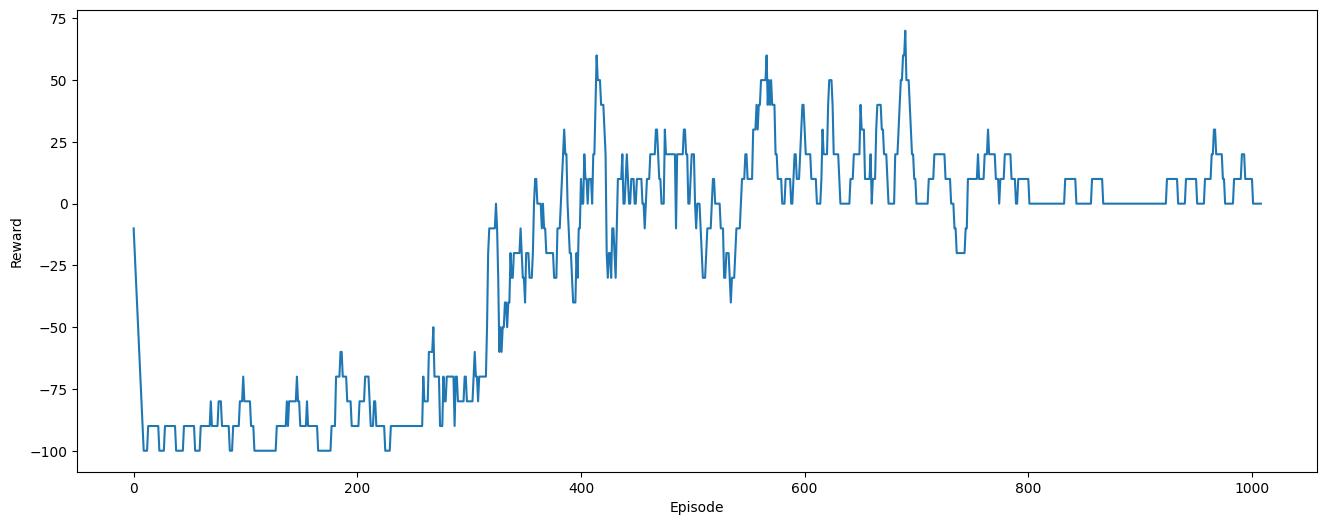

In [19]:
#sns.lineplot(steps, label="steps")
fig, ax = plt.subplots(figsize=(16,6))
sns.lineplot(np.convolve(rewards, [1 for _ in range(10)]))
plt.xlabel("Episode")
plt.ylabel("Reward")

Text(0, 0.5, 'Loss')

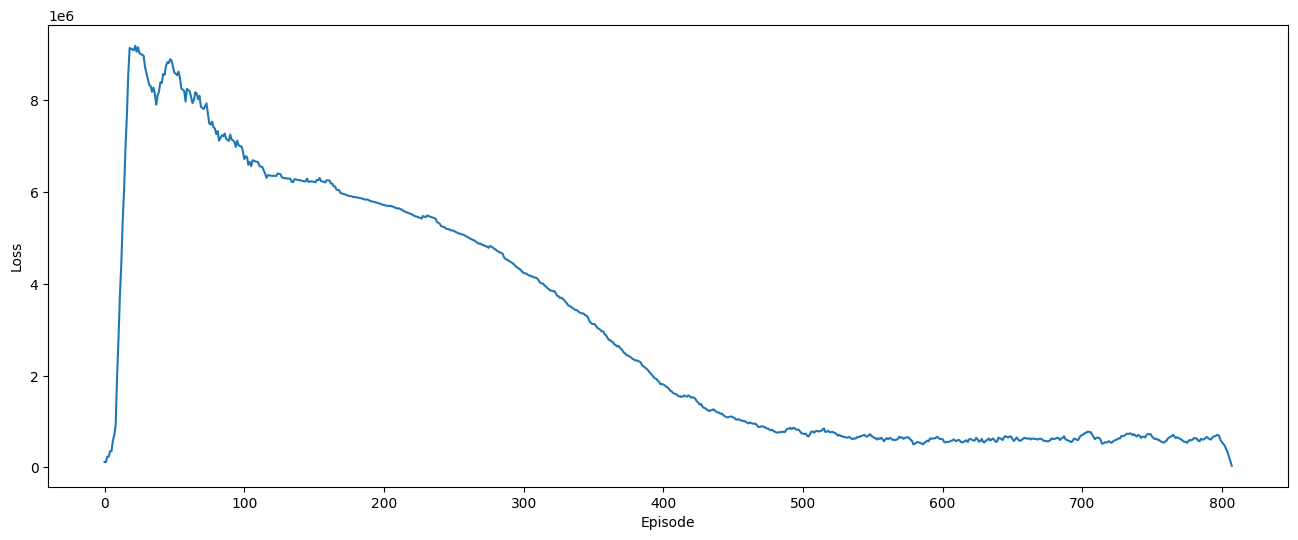

In [20]:
fig, ax = plt.subplots(figsize=(16,6))
sns.lineplot(np.convolve(losses, [1 for _ in range(10)]), ax=ax)
plt.xlabel("Episode")
plt.ylabel("Loss")

Text(0, 0.5, 'Reward')

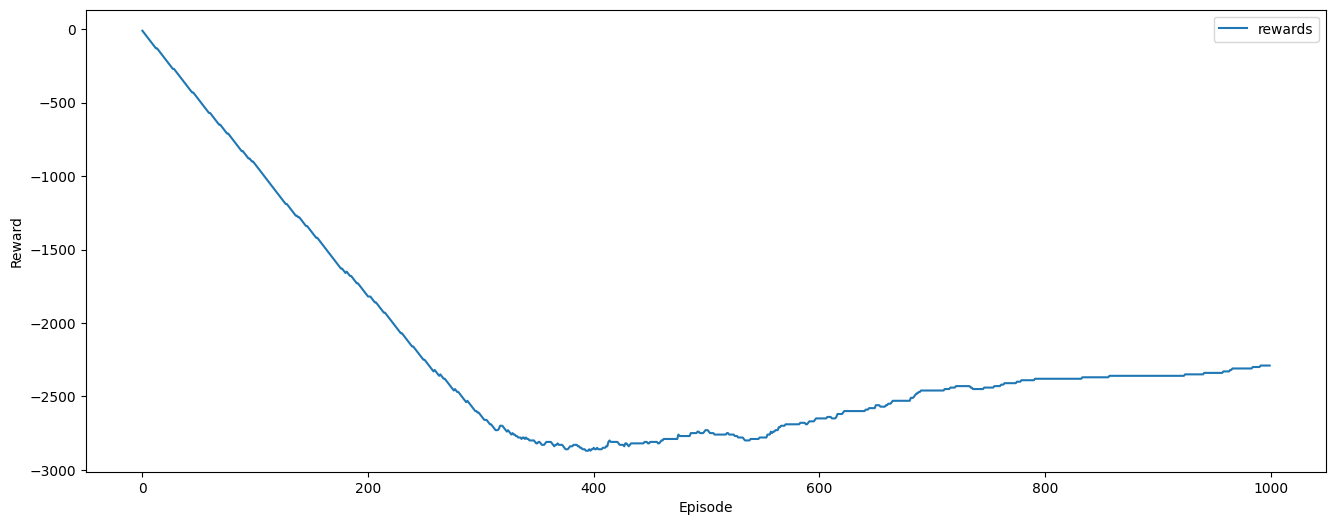

In [21]:
fig, ax = plt.subplots(figsize=(16,6))
sns.lineplot(np.cumsum(rewards), label="rewards", ax=ax)
plt.xlabel("Episode")
plt.ylabel("Reward")

In [22]:
online_model.save(f"models/{model_name}.keras")